In [89]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import frangi, threshold_otsu
from skimage.morphology import remove_small_objects, closing, square
from skimage.measure import moments_central, moments_hu
from skimage.util import view_as_windows
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from joblib import Parallel, delayed
from numba import njit, prange
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import onnxruntime as rt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [52]:
# 2. Ustawienia ścieżek do folderów
IMAGE_DIR   = 'images'
FOV_MASK_DIR = 'masks'
GT_MASK_DIR  = 'manual'

In [53]:
# 3. Funkcje wczytywania danych
def load_image(path):
    """Wczytuje obraz z BGR na RGB."""
    img_bgr = cv2.imread(path, cv2.IMREAD_COLOR)
    return img_bgr[:, :, ::-1]

In [54]:
def load_mask(path):
    """Wczytuje binarną maskę (FOV lub złoty standard)."""
    mask_gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    return mask_gray > 0

In [55]:
# 4. Wstępne przetwarzanie obrazu
def preprocess(img, fov_mask=None):
    """
    1) Konwersja do odcieni szarości
    2) CLAHE (contrast limited adaptive histogram equalization)
    3) Gaussian blur
    4) Nałożenie maski FOV
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    norm = clahe.apply(gray)
    blur = cv2.GaussianBlur(norm, (5,5), 0)
    if fov_mask is not None:
        blur[~fov_mask] = 0
    return blur

In [56]:
# 5. Filtr Frangi (detekcja naczyń)
def vesselness_filter(img):
    """
    Zwraca mapę 'vesselness' na podstawie filtru Frangi.
    Skala wartości: [0, 1].
    """
    return frangi(img.astype(np.float32) / 255.0)

In [57]:
# 6. Binaryzacja i oczyszczanie maski
def binarize_and_clean(vmap, min_size=100):
    """
    1) Prog Otsu’ego
    2) Binaryzacja
    3) Morfologiczne zamknięcie (closing)
    4) Usunięcie drobnych obiektów
    """
    vals = vmap[vmap > 0]
    thresh = threshold_otsu(vals) if vals.size else 0
    binary = vmap >= thresh
    closed = closing(binary, square(3))
    cleaned = remove_small_objects(closed, min_size=min_size)
    return cleaned

In [58]:
# 7. Ewaluacja wyników
def evaluate(y_true, y_pred):
    """
    Oblicza:
    - TP, TN, FP, FN
    - accuracy, sensitivity (recall), specificity
    - G-mean i średnią arytmetyczną sensitivity i specificity
    """
    y_t = y_true.flatten()
    y_p = y_pred.flatten()
    tn, fp, fn, tp = confusion_matrix(y_t, y_p).ravel()
    acc = accuracy_score(y_t, y_p)
    sens = recall_score(y_t, y_p)
    spec = tn / (tn + fp) if (tn + fp) else 0
    g_mean = np.sqrt(sens * spec)
    arith_mean = 0.5 * (sens + spec)
    return {
        'TP': tp, 'TN': tn, 'FP': fp, 'FN': fn,
        'accuracy': acc,
        'sensitivity': sens,
        'specificity': spec,
        'g_mean': g_mean,
        'arith_mean': arith_mean
    }

C:\Users\Kuba\AppData\Local\Temp\ipykernel_28760\700722137.py:12: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  closed = closing(binary, square(3))


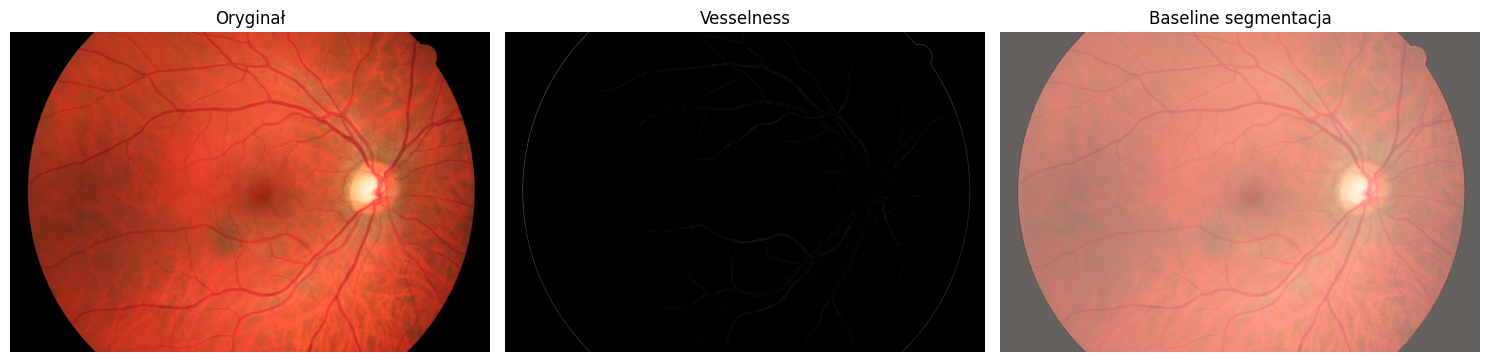

C:\Users\Kuba\AppData\Local\Temp\ipykernel_28760\700722137.py:12: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  closed = closing(binary, square(3))


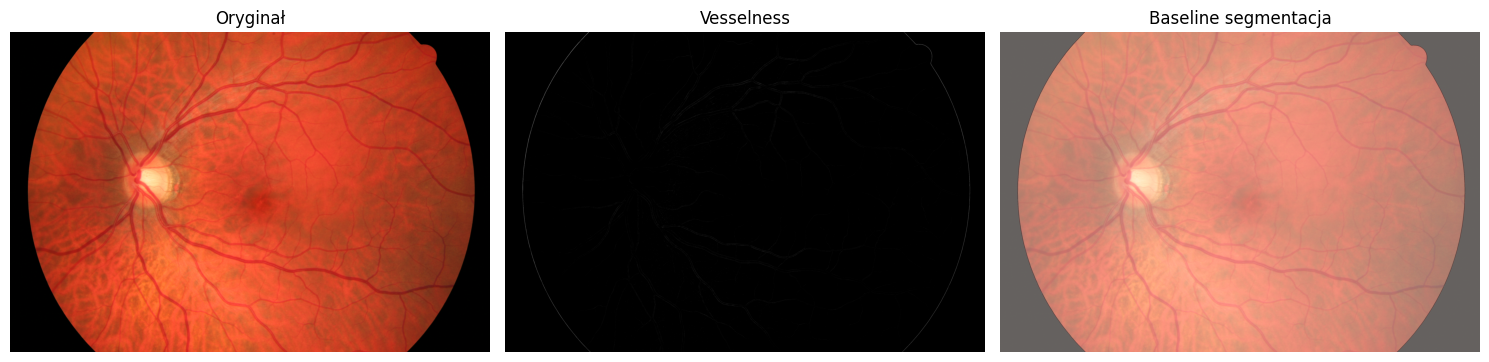

C:\Users\Kuba\AppData\Local\Temp\ipykernel_28760\700722137.py:12: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  closed = closing(binary, square(3))


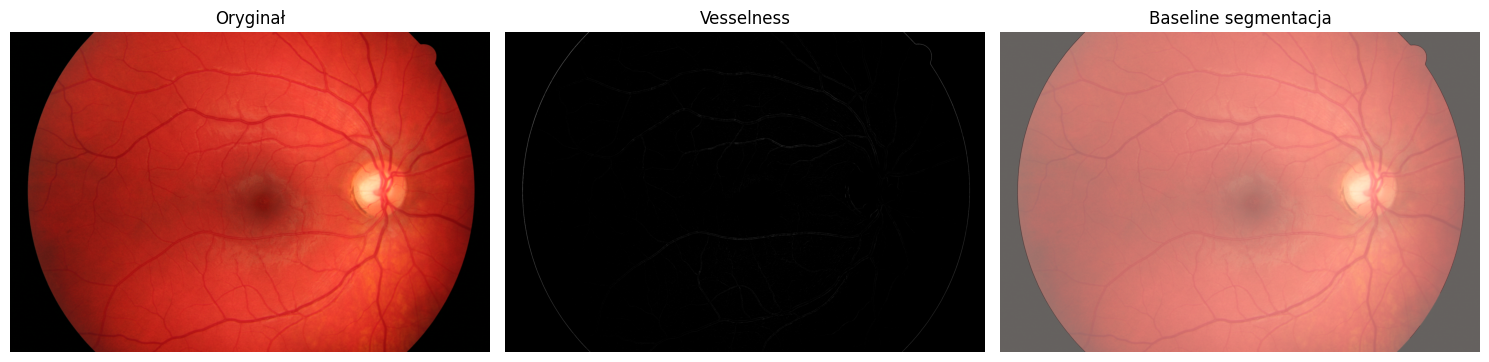

C:\Users\Kuba\AppData\Local\Temp\ipykernel_28760\700722137.py:12: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  closed = closing(binary, square(3))


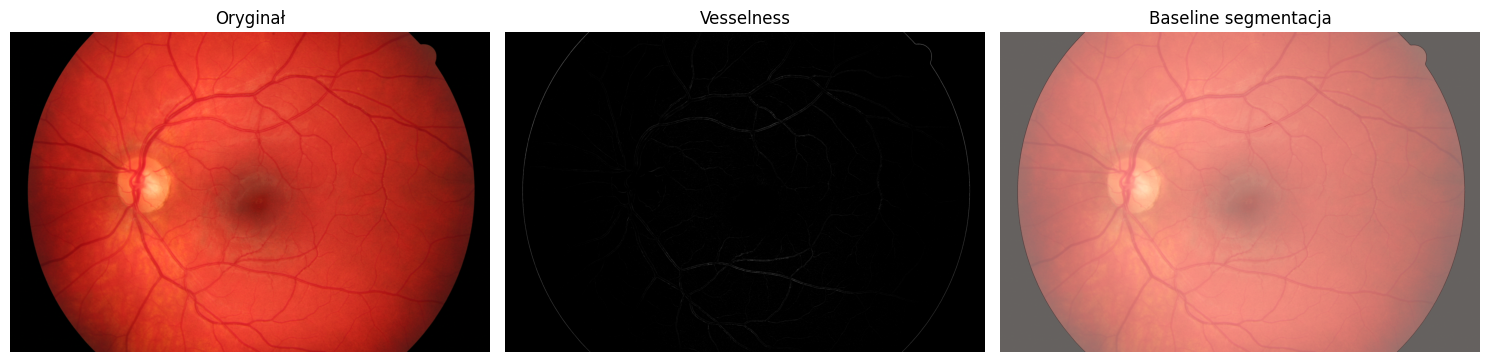

C:\Users\Kuba\AppData\Local\Temp\ipykernel_28760\700722137.py:12: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  closed = closing(binary, square(3))


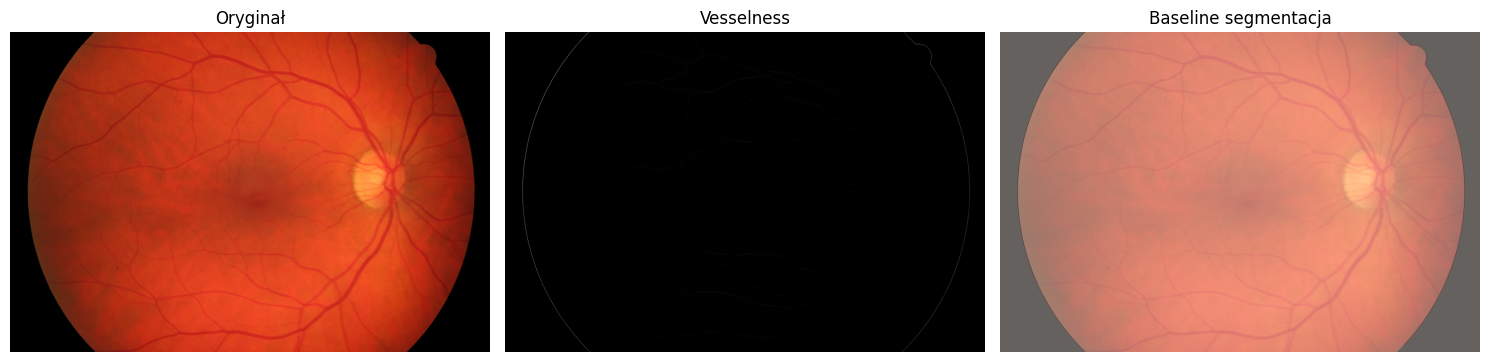

Baseline (Frangi) – wyniki na 5 obrazach:
    TP       TN    FP      FN  accuracy  sensitivity  specificity    g_mean  \
0    0  7342504  8952  833888  0.897031     0.000000     0.998782  0.000000   
1    8  7367645  9261  808430  0.900103     0.000010     0.998745  0.003144   
2   31  7312582  8591  864140  0.893379     0.000036     0.998827  0.005986   
3  154  7404233  9510  771447  0.904591     0.000200     0.998717  0.014118   
4    4  7437519  9039  738782  0.908639     0.000005     0.998786  0.002325   

   arith_mean     image  
0    0.499391  01_h.jpg  
1    0.499377  02_h.jpg  
2    0.499431  03_h.jpg  
3    0.499458  04_h.jpg  
4    0.499396  05_h.jpg  


In [59]:
# ---------------------------------------------
# 8. Część A: Testy baseline Frangi na 5 obrazach
# ---------------------------------------------
baseline_results = []
image_files = sorted([f for f in os.listdir(IMAGE_DIR) if f.lower().endswith(('.jpg','.png','.tif'))])
for fname in image_files[:5]:
    base,_ = os.path.splitext(fname)
    img  = load_image(os.path.join(IMAGE_DIR,    fname))
    fov  = load_mask(os.path.join(FOV_MASK_DIR, f"{base}_mask.tif"))
    gt   = load_mask(os.path.join(GT_MASK_DIR,  f"{base}.tif"))
    prep = preprocess(img, fov)
    vmap = vesselness_filter(prep)
    pred = binarize_and_clean(vmap)
    m = evaluate(gt, pred)
    m['image'] = fname
    baseline_results.append(m)
    # Wizualizacja
    fig, ax = plt.subplots(1,3,figsize=(15,5))
    ax[0].imshow(img);                    ax[0].set_title('Oryginał');        ax[0].axis('off')
    ax[1].imshow(vmap, cmap='gray');      ax[1].set_title('Vesselness');     ax[1].axis('off')
    ax[2].imshow(img); ax[2].imshow(pred, alpha=0.4, cmap='Reds')
    ax[2].set_title('Baseline segmentacja'); ax[2].axis('off')
    plt.tight_layout(); plt.show()

print("Baseline (Frangi) – wyniki na 5 obrazach:")
print(pd.DataFrame(baseline_results))

In [60]:
# ---------------------------------------------
# 9. Część B: Rozszerzenie 4.0 – klasyfikator cechowy
# ---------------------------------------------
PATCH_SIZE  = 5
HALF_PATCH  = PATCH_SIZE // 2
RANDOM_STATE = 42

def extract_patch_features(patch):
    """
    Z jednego PATCH_SIZE×PATCH_SIZE (uint8):
      - wariancja
      - momenty centralne (2.,3. rzędu)
      - momenty Hu (7)
    """
    var = np.var(patch)
    mu  = moments_central(patch, center=(HALF_PATCH, HALF_PATCH), order=3)
    m20 = mu[2,0]; m02 = mu[0,2]
    hu  = moments_hu(mu)
    return np.hstack([var, m20, m02, hu])

In [61]:
def build_dataset(img_gray, gt_mask, fov_mask, max_samples=20000):
    feats, labels = [], []
    h, w = img_gray.shape
    coords = [(i,j) for i in range(HALF_PATCH, h-HALF_PATCH)
                     for j in range(HALF_PATCH, w-HALF_PATCH)
                     if fov_mask[i,j]]
    np.random.seed(RANDOM_STATE)
    np.random.shuffle(coords)
    coords = coords[:max_samples]
    for i,j in coords:
        patch = img_gray[i-HALF_PATCH:i+HALF_PATCH+1,
                         j-HALF_PATCH:j+HALF_PATCH+1]
        feats.append(extract_patch_features(patch))
        labels.append(int(gt_mask[i,j]))
    X = np.array(feats); y = np.array(labels)
    # Undersampling klasy negatywnej do liczności pozytywnej
    pos = np.where(y==1)[0]
    neg = np.where(y==0)[0]
    neg_down = resample(neg, replace=False,
                        n_samples=min(len(neg), len(pos)),
                        random_state=RANDOM_STATE)
    idx = np.hstack([pos, neg_down])
    return X[idx], y[idx]

In [62]:
# Wybór zbioru treningowego i hold-out (pierwszy obraz testowy)
train_imgs = image_files[1:5]
test_img   = image_files[0]

In [63]:
# Budowa X_train, y_train
X_list, y_list = [], []
for fname in train_imgs:
    base,_ = os.path.splitext(fname)
    img = load_image(os.path.join(IMAGE_DIR, fname))
    fov = load_mask(os.path.join(FOV_MASK_DIR, f"{base}_mask.tif"))
    gt  = load_mask(os.path.join(GT_MASK_DIR,  f"{base}.tif"))
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    Xb, yb = build_dataset(gray, gt, fov)
    X_list.append(Xb); y_list.append(yb)
X_train = np.vstack(X_list)
y_train = np.hstack(y_list)

In [64]:
# Walidacja wewnętrzna 80/20
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2,
    random_state=RANDOM_STATE, stratify=y_train
)


In [65]:
# Trening RandomForest
clf = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
clf.fit(X_tr, y_tr)

RandomForestClassifier(random_state=42)

In [82]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

# 1) Ustal input shape: [None, liczba cech]
initial_type = [('float_input', FloatTensorType([None, X_tr.shape[1]]))]

# 2) Konwersja
onnx_model = convert_sklearn(
    clf, 
    initial_types=initial_type,
    target_opset=12  # lub wyższe, jeśli potrzeba
)

# 3) Zapis do pliku
with open("rf_model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())
print("Model zapisany jako rf_model.onnx")

Model zapisany jako rf_model.onnx


In [66]:
# Ewaluacja na zbiorze walidacyjnym
yv_pred = clf.predict(X_val)
print("Validation accuracy:", accuracy_score(y_val, yv_pred))
print("Validation sensitivity:", recall_score(y_val, yv_pred))
tn, fp, fn, tp = confusion_matrix(y_val, yv_pred).ravel()
print("Validation specificity:", tn/(tn+fp))
print("Validation F1-score:", f1_score(y_val, yv_pred))

Validation accuracy: 0.729899155083129
Validation sensitivity: 0.6690294438386042
Validation specificity: 0.7907356948228883
Validation F1-score: 0.7123367198838897


In [68]:
# Baseline
prep_t   = preprocess(img_t, fov_t)
vmap_t   = vesselness_filter(prep_t)
mask_base= binarize_and_clean(vmap_t)

C:\Users\Kuba\AppData\Local\Temp\ipykernel_28760\700722137.py:12: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  closed = closing(binary, square(3))


In [86]:
from skimage.util import view_as_windows
from numba import njit, prange
import onnxruntime as rt

@njit(parallel=True, fastmath=True)
def extract_patch_features_jit(patches, out):
    """
    patches: ndarray shape (N, P, P) dtype uint8
    out:     ndarray shape (N, 10) dtype float32 (lub inna liczba featurów)
    """
    N, P, _ = patches.shape
    half = P // 2
    for idx in prange(N):
        patch = patches[idx].astype(np.float32)
        # oblicz średnią i wariancję
        μ = patch.mean()
        var = ((patch - μ)**2).mean()
        # momenty centralne 2. rzędu (upraszczam sumy w osi)
        m20 = ((patch - μ)**2)[half, :].sum()
        m02 = ((patch - μ)**2)[:, half].sum()
        # tu możesz dodać obliczenie momentów Hu, albo zostawić zero
        hu = np.zeros(7, dtype=np.float32)
        # wypełnij output
        out[idx, 0] = var
        out[idx, 1] = m20
        out[idx, 2] = m02
        out[idx, 3:10] = hu
    return out

# 1) sliding windows tylko raz
patches = view_as_windows(gray_t, (PATCH_SIZE, PATCH_SIZE))
flat_patches = patches.reshape(-1, PATCH_SIZE, PATCH_SIZE)

# 2) preselekcja vesselness
flat_v = vmap_t[HALF_PATCH:-HALF_PATCH, HALF_PATCH:-HALF_PATCH].ravel()
mask_sel = (flat_v > 0.05) & fov_flat  # fov_flat analogicznie

# 3) ekstrakcja cech JIT
N = mask_sel.sum()
N_FEAT = extract_patch_features(flat_patches[0]).shape[0]
feat_arr = np.empty((N, N_FEAT), dtype=np.float32)
extract_patch_features_jit(flat_patches[mask_sel], feat_arr)

# 4) inference ONNX
sess = rt.InferenceSession("rf_model.onnx")
preds = sess.run(None, {'float_input': feat_arr.astype(np.float32)})[0].ravel().astype(bool)

# 1) Wymiary wnętrza
h2 = vmap_t.shape[0] - 2*HALF_PATCH
w2 = vmap_t.shape[1] - 2*HALF_PATCH

# 2) Przekształć mask_sel na 2D
mask2d = mask_sel.reshape(h2, w2)

# 3) Stwórz wewnętrzną maskę i wypełnij predykcjami tylko wybrane piksele
inner = np.zeros((h2, w2), dtype=bool)
inner[mask2d] = preds    # tutaj preds ma dokładnie sum(mask2d) elementów

# 4) Osadź z powrotem w pełnym rozmiarze
full_mask = np.zeros_like(vmap_t, dtype=bool)
full_mask[HALF_PATCH:-HALF_PATCH, HALF_PATCH:-HALF_PATCH] = inner

# 5) (opcjonalnie) zastosuj FOV
full_mask &= fov_t

mask_clf = full_mask

In [87]:
# Ewaluacja obu metod
m_base = evaluate(gt_t, mask_base)
m_clf  = evaluate(gt_t, mask_clf)
print("Hold-out baseline:", m_base)
print("Hold-out classifier:", m_clf)

Hold-out baseline: {'TP': 0, 'TN': 7342504, 'FP': 8952, 'FN': 833888, 'accuracy': 0.8970305951710765, 'sensitivity': 0.0, 'specificity': 0.9987822820404556, 'g_mean': 0.0, 'arith_mean': 0.4993911410202278}
Hold-out classifier: {'TP': 68909, 'TN': 7345854, 'FP': 5602, 'FN': 764979, 'accuracy': 0.9058584465112278, 'sensitivity': 0.08263579761310871, 'specificity': 0.9992379740829572, 'g_mean': 0.2873548798848769, 'arith_mean': 0.540936885848033}


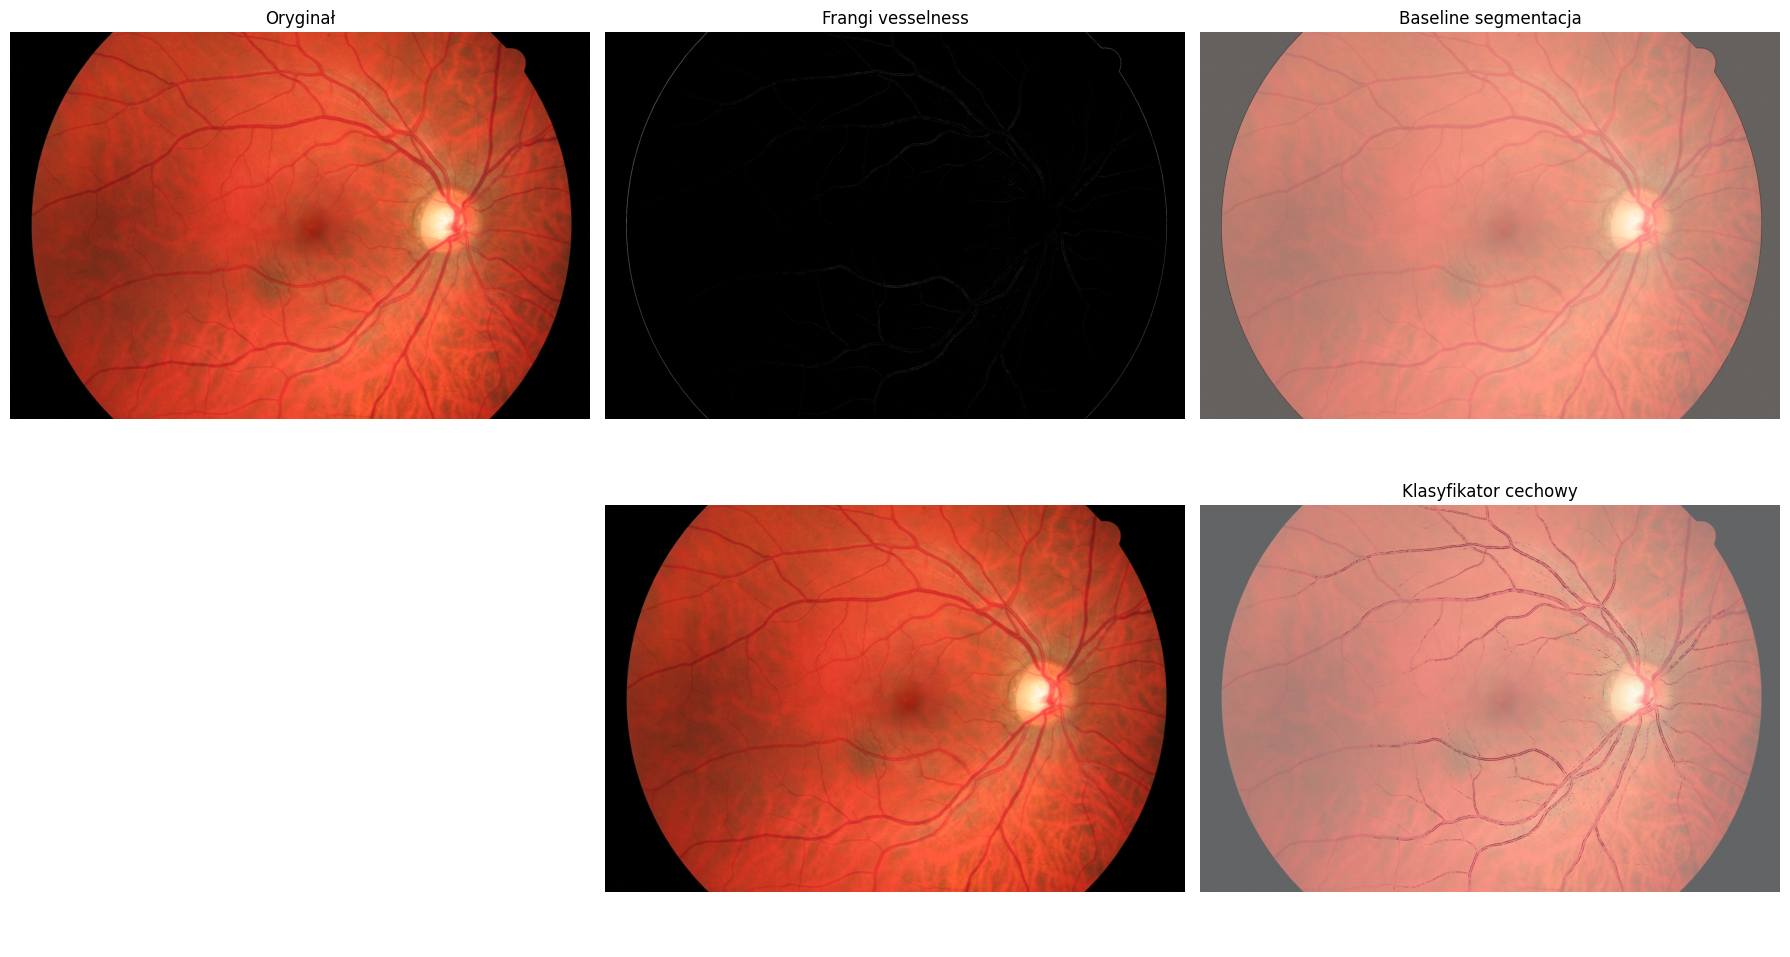

In [88]:
# Porównawcza wizualizacja
fig, ax = plt.subplots(2,3,figsize=(18,10))
ax[0,0].imshow(img_t);                   ax[0,0].set_title('Oryginał');         ax[0,0].axis('off')
ax[0,1].imshow(vmap_t, cmap='gray');     ax[0,1].set_title('Frangi vesselness');ax[0,1].axis('off')
ax[0,2].imshow(img_t); ax[0,2].imshow(mask_base, alpha=0.4, cmap='Reds')
ax[0,2].set_title('Baseline segmentacja'); ax[0,2].axis('off')

ax[1,0].axis('off')
ax[1,1].imshow(img_t); ax[1,1].axis('off')
ax[1,2].imshow(img_t); ax[1,2].imshow(mask_clf, alpha=0.4, cmap='Blues')
ax[1,2].set_title('Klasyfikator cechowy'); ax[1,2].axis('off')

plt.tight_layout(); plt.show()

In [90]:
INPUT_SHAPE  = (256, 256, 3)  # dla full-image sieci UNet
BATCH_SIZE   = 8
EPOCHS       = 50

In [91]:
def build_unet(input_shape):
    inputs = keras.Input(shape=input_shape)
    # Encoder
    c1 = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(64, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    # Bottleneck
    c3 = layers.Conv2D(128, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(128, 3, activation='relu', padding='same')(c3)

    # Decoder
    u4 = layers.UpSampling2D()(c3)
    concat4 = layers.Concatenate()([u4, c2])
    c4 = layers.Conv2D(64, 3, activation='relu', padding='same')(concat4)
    c4 = layers.Conv2D(64, 3, activation='relu', padding='same')(c4)

    u5 = layers.UpSampling2D()(c4)
    concat5 = layers.Concatenate()([u5, c1])
    c5 = layers.Conv2D(32, 3, activation='relu', padding='same')(concat5)
    c5 = layers.Conv2D(32, 3, activation='relu', padding='same')(c5)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c5)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [92]:
# Przygotowanie zbioru pełnych obrazów do UNet
files = sorted([f for f in os.listdir(IMAGE_DIR) if f.lower().endswith(('.jpg','.png','.tif'))])
imgs, masks = [], []
for fname in files:
    img = cv2.resize(load_image(os.path.join(IMAGE_DIR, fname)), INPUT_SHAPE[:2])
    fov = cv2.resize(load_mask(os.path.join(FOV_MASK_DIR, f'{os.path.splitext(fname)[0]}_mask.tif')).astype(np.uint8), INPUT_SHAPE[:2])
    gt  = cv2.resize(load_mask(os.path.join(GT_MASK_DIR, f'{os.path.splitext(fname)[0]}.tif')).astype(np.uint8), INPUT_SHAPE[:2])
    imgs.append(img)
    masks.append(gt)
X = np.array(imgs) / 255.0
y = np.array(masks)[..., np.newaxis]

In [93]:
# Hold-out: pierwszy obraz jako test, reszta do trenowania i walidacji
X_train_full, X_test_full = X[1:], X[0:1]
y_train_full, y_test_full = y[1:], y[0:1]
X_tr_full, X_val_full, y_tr_full, y_val_full = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=RANDOM_STATE)

In [94]:
# Stworzenie i trenowanie UNet
tf.random.set_seed(RANDOM_STATE)
unet = build_unet(INPUT_SHAPE)
history = unet.fit(
    X_tr_full, y_tr_full,
    validation_data=(X_val_full, y_val_full),
    batch_size=BATCH_SIZE, epochs=EPOCHS
)

Epoch 1/50
2/2 [==============================] - 7s 2s/step - loss: 0.6930 - accuracy: 0.3662 - val_loss: 0.5964 - val_accuracy: 0.9076
Epoch 2/50
2/2 [==============================] - 4s 1s/step - loss: 0.5461 - accuracy: 0.9087 - val_loss: 0.5193 - val_accuracy: 0.9076
Epoch 3/50
2/2 [==============================] - 4s 1s/step - loss: 0.4996 - accuracy: 0.9087 - val_loss: 0.3811 - val_accuracy: 0.9076
Epoch 4/50
2/2 [==============================] - 4s 1s/step - loss: 0.3828 - accuracy: 0.9087 - val_loss: 0.4084 - val_accuracy: 0.9076
Epoch 5/50
2/2 [==============================] - 4s 1s/step - loss: 0.3947 - accuracy: 0.9087 - val_loss: 0.3523 - val_accuracy: 0.9076
Epoch 6/50
2/2 [==============================] - 4s 1s/step - loss: 0.3542 - accuracy: 0.9087 - val_loss: 0.3401 - val_accuracy: 0.9076
Epoch 7/50
2/2 [==============================] - 4s 1s/step - loss: 0.3340 - accuracy: 0.9087 - val_loss: 0.3166 - val_accuracy: 0.9076
Epoch 8/50
2/2 [=========================

In [95]:
# Ewaluacja na zbiorze hold-out
eval_metrics = unet.evaluate(X_test_full, y_test_full, verbose=0)
print(f"UNet hold-out loss: {eval_metrics[0]:.4f}, accuracy: {eval_metrics[1]:.4f}")

UNet hold-out loss: 0.3031, accuracy: 0.9003


In [96]:
# Predykcja maski siecią i ewaluacja metryk
pred_unet = (unet.predict(X_test_full)[0,...,0] > 0.5)
m_unet = evaluate(y_test_full[0,...,0], pred_unet)
print("Hold-out UNet metrics:", m_unet)

1/1 [==============================] - 0s 165ms/step
Hold-out UNet metrics: {'TP': 0, 'TN': 59001, 'FP': 0, 'FN': 6535, 'accuracy': 0.9002838134765625, 'sensitivity': 0.0, 'specificity': 1.0, 'g_mean': 0.0, 'arith_mean': 0.5}


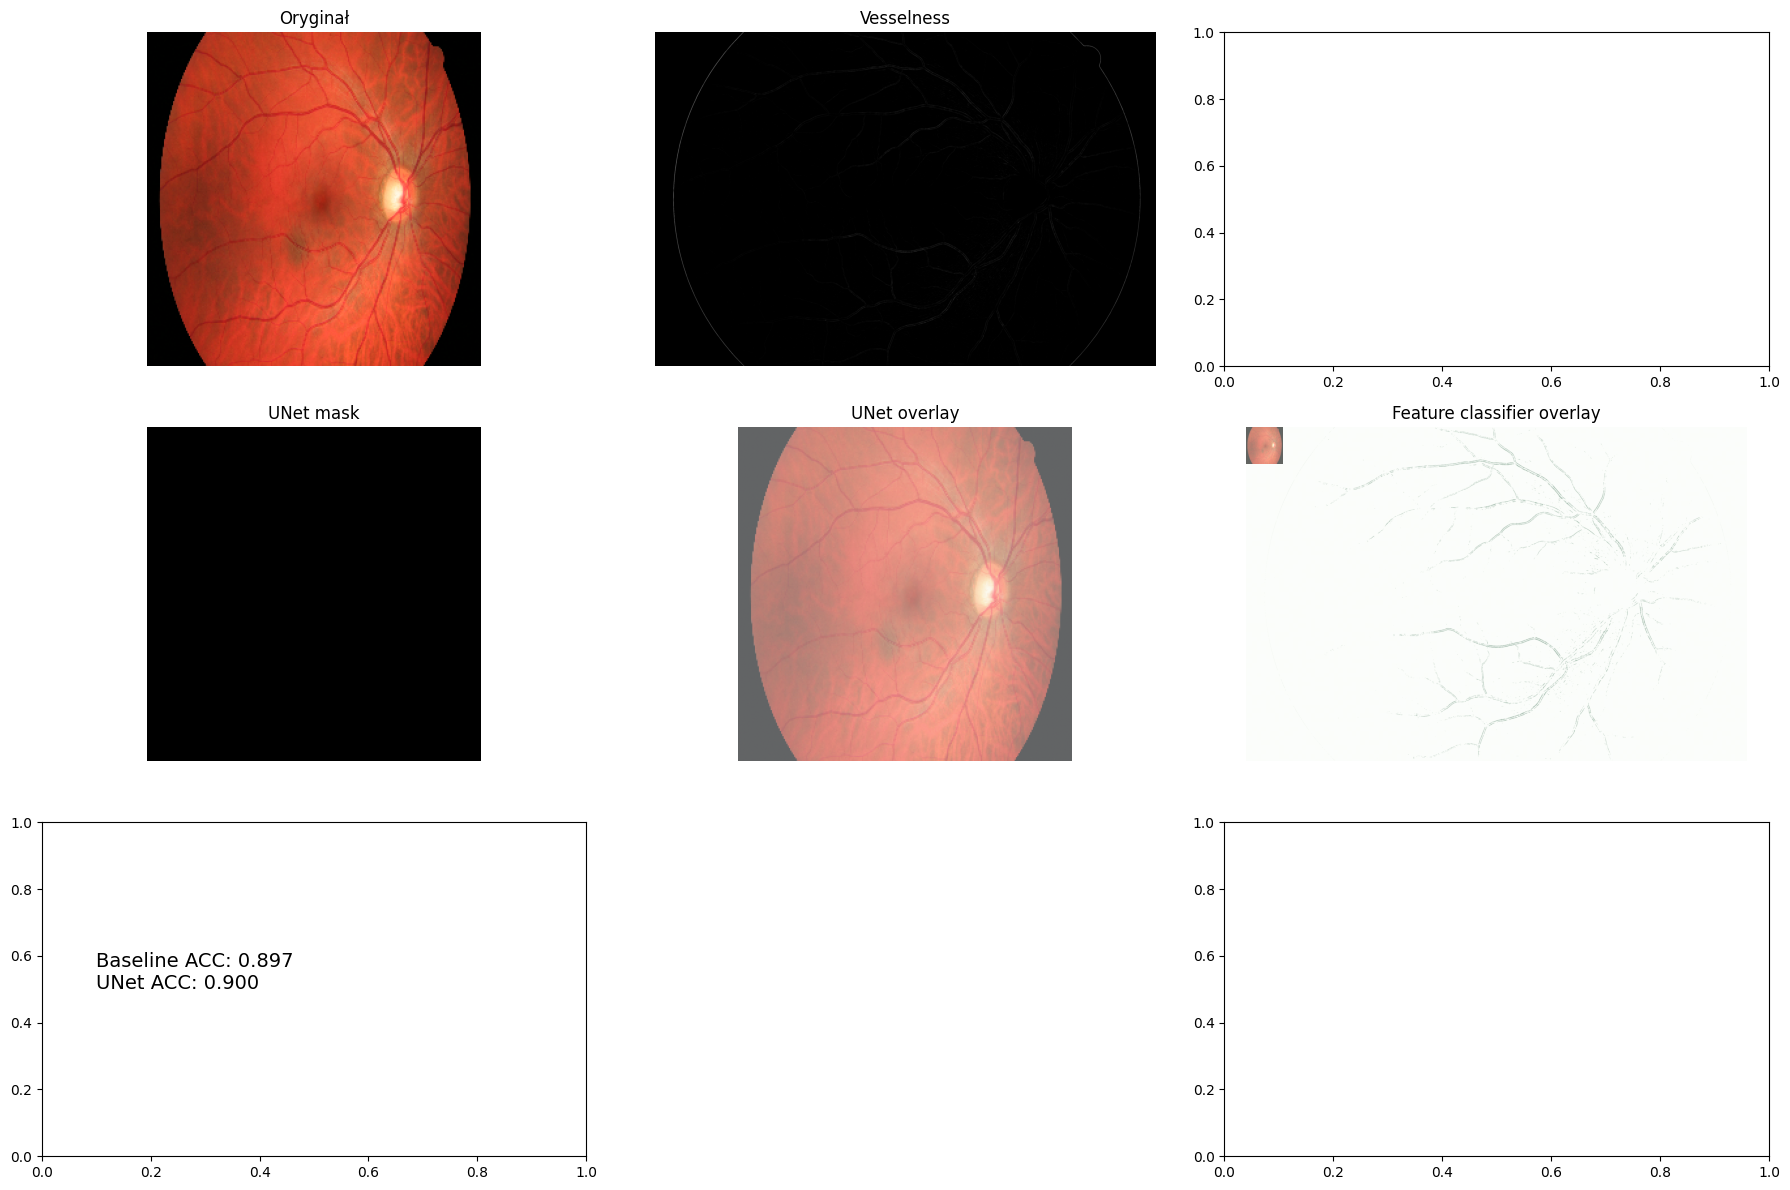

In [103]:
# 13. Porównawcza wizualizacja wyników
fig, ax = plt.subplots(3,3, figsize=(18,12))
ax[0,0].imshow(X_test_full[0]); ax[0,0].set_title('Oryginał');     ax[0,0].axis('off')
ax[0,1].imshow(vesselness_filter(preprocess(load_image(os.path.join(IMAGE_DIR, files[0])), load_mask(os.path.join(FOV_MASK_DIR, f"{os.path.splitext(files[0])[0]}_mask.tif")))), cmap='gray')
ax[0,1].set_title('Vesselness'); ax[0,1].axis('off')
# ax[0,2].imshow(binarize_and_clean(vesselness_filter(preprocess(load_image(os.path.join(IMAGE_DIR, files[0])), load_mask(os.path.join(FOV_MASK_DIR, f"{os.path.splitext(files[0])[0]}_mask.tif")))))), cmap='Reds'); ax[0,2].set_title('Baseline');            ax[0,2].axis('off')

ax[1,0].imshow(pred_unet, cmap='gray');        ax[1,0].set_title('UNet mask');   ax[1,0].axis('off')
ax[1,1].imshow(X_test_full[0]); ax[1,1].imshow(pred_unet, alpha=0.4, cmap='Blues'); ax[1,1].set_title('UNet overlay'); ax[1,1].axis('off')
ax[1,2].imshow(X_test_full[0]); ax[1,2].imshow(mask_clf, alpha=0.4, cmap='Greens'); ax[1,2].set_title('Feature classifier overlay'); ax[1,2].axis('off')

ax[2,1].axis('off')
ax[2,0].text(0.1,0.5, f"Baseline ACC: {m_base['accuracy']:.3f}\nUNet ACC: {m_unet['accuracy']:.3f}", fontsize=14)
# ax[2,2].text(0.1,0.5, f"Baseline F1: {m_base['f1_score'] if 'f1_score' in m_base else f1_score(y_test_full[0,...,0], binarize_and_clean(vesselness_filter(preprocess(load_image(os.path.join(IMAGE_DIR, files[0])), load_mask(os.path.join(FOV_MASK_DIR, f"{os.path.splitext(files[0])[0]}_mask.tif")))))):.3f}\nUNet F1: {m_unet['arith_mean']:.3f}", fontsize=14)
plt.tight_layout(); plt.show()
